<a href="https://colab.research.google.com/github/timgluz/colab_notebooks/blob/master/HumanPoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting data

```
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
```


In [0]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [0]:
import scipy.io as sio

train = sio.loadmat('train_32x32.mat')
test = sio.loadmat('test_32x32.mat')

In [0]:
sorted(train.keys())

['X', '__globals__', '__header__', '__version__', 'y']

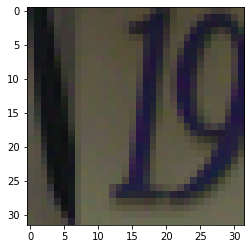

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = train['X'][:, :, :, 0];
imgplot = plt.imshow(img)


In [0]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")


In [0]:
import json

# load image instance
def load_json(file_path):
  with open(file_path) as fp:
    return json.load(fp)

training_dt = load_json("annotations/instances_train2017.json")
keypoint_dt = load_json("annotations/person_keypoints_train2017.json")


#### Keypoints data structure

```json
{"annotations": [
  { "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
  }
]
```

In [20]:
keypoint_labels = keypoint_dt["categories"][0]['keypoints']

keypoint_labels

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']

In [6]:
example = training_dt["images"][0]
example

{'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'date_captured': '2013-11-14 11:18:45',
 'file_name': '000000391895.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'height': 360,
 'id': 391895,
 'license': 3,
 'width': 640}

In [7]:
captions = [dt for dt in keypoint_dt["annotations"] if dt["image_id"] == example["id"]]
caption = captions[0]
caption

{'area': 14107.2713,
 'bbox': [339.88, 22.16, 153.88, 300.73],
 'category_id': 1,
 'id': 202758,
 'image_id': 391895,
 'iscrowd': 0,
 'keypoints': [368,
  61,
  1,
  369,
  52,
  2,
  0,
  0,
  0,
  382,
  48,
  2,
  0,
  0,
  0,
  368,
  84,
  2,
  435,
  81,
  2,
  362,
  125,
  2,
  446,
  125,
  2,
  360,
  153,
  2,
  0,
  0,
  0,
  397,
  167,
  1,
  439,
  166,
  1,
  369,
  193,
  2,
  461,
  234,
  2,
  361,
  246,
  2,
  474,
  287,
  2],
 'num_keypoints': 14,
 'segmentation': [[352.55,
   146.82,
   353.61,
   137.66,
   356.07,
   112.66,
   357.13,
   94.7,
   357.13,
   84.49,
   363.12,
   73.92,
   370.16,
   68.64,
   370.16,
   66.53,
   368.4,
   63.71,
   368.05,
   54.56,
   361,
   53.85,
   356.07,
   50.33,
   356.43,
   46.46,
   364.17,
   42.23,
   369.1,
   35.89,
   371.22,
   30.96,
   376.85,
   26.39,
   383.54,
   22.16,
   391.29,
   23.22,
   400.79,
   27.79,
   402.2,
   30.61,
   404.32,
   34.84,
   406.08,
   38.71,
   406.08,
   41.53,
   406.08

In [26]:
from collections import namedtuple

BoundingBox = namedtuple("BoundingBox", ['x1', 'y1', 'x2', 'y2'])

def boundingbox_from_caption(caption):
  x1,y1, w,h = caption['bbox']
  return BoundingBox(x1, y1, x1 + w, y1 + h)

bbox = boundingbox_from_caption(caption)
bbox

BoundingBox(x1=339.88, y1=22.16, x2=493.76, y2=322.89000000000004)

In [23]:
from collections import namedtuple;

Keypoint = namedtuple('Keypoint', ['x', 'y', 'visibility', 'label']);

def keypoints_from_caption(caption, labels = []):
  keypoints = []
  for i in range(0, len(caption['keypoints']), 3):
    pt = Keypoint(caption['keypoints'][i],
                  caption['keypoints'][i + 1],
                  caption['keypoints'][i + 2],
                  str(labels[i // 3]))
    keypoints.append(pt)
  return keypoints

keypoint_labels = keypoint_dt["categories"][0]['keypoints']
keypoints = keypoints_from_caption(caption, keypoint_labels)
keypoints[0]

Keypoint(x=368, y=61, visibility=1, label='nose')

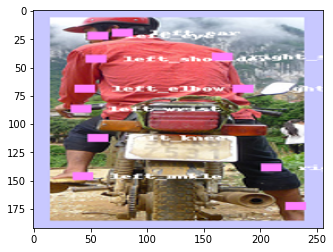

In [32]:
# load image and draw items
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
%matplotlib inline

def load_image(image_path):
  return Image.open(image_path)

def show_image(im):
  imshow(im)

def crop_image(im, bbox):
  return im.crop(bbox)

def draw_captions(im, bbox = None, keypoints = None):
  if im is None:
    return

  draw = ImageDraw.Draw(im)
  if bbox is not None:
    draw.rectangle(bbox, outline=(200,200,255,0), width=10)
  if keypoints is not None:
    for pt in keypoints:
      if pt.visibility == 2:
        draw.rectangle((pt.x, pt.y, pt.x+10, pt.y + 10), fill=(255,128,255,0))
        draw.text((pt.x + 20, pt.y), pt.label)
  return im

image_path = "train2017/{}".format(example["file_name"])
im = load_image(image_path)
im_captioned = draw_captions(im, bbox, keypoints)
im_crop = crop_image(im_captioned, bbox)
im_resized = im_crop.resize((256, 192))
show_image(im_resized)